Stroke — an acute violation of the blood supply to the brain, characterized by a sudden (within a few minutes, hours) the appearance of focal and / or general cerebral neurological symptoms that persist for more than 24 hours or lead to the death of the patient in a shorter period of time due to cerebrovascular pathology.

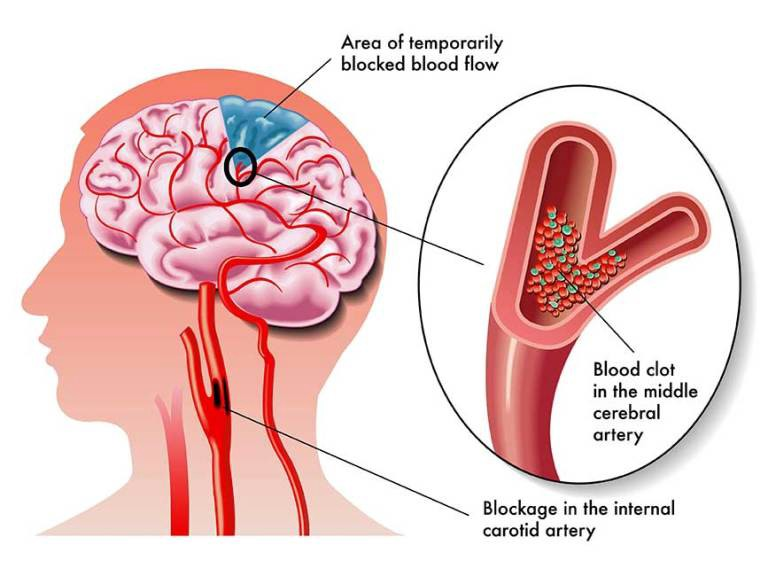

Let's import the main libraries and see what kind of data we have.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [ ]:
df=pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head(5)

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df.describe()

In total, we have 9 variables and 1 target. The fact of a stroke is affected by the following parameters:
1) Gender
2) Average glucose level
3) BMI
4) Smoking
5) Type of work
6) Was the person married (amazing, isn't it?)
7) Where does the person live
8) Does a person suffer from hypertension
9) Does the patient have a history of heart disease.
Let's do a simple visual analysis of our data.

In [ ]:
sns.histplot(df['Residence_type'])

In [ ]:
sns.histplot(df['work_type'])

In [ ]:
sns.histplot(df['ever_married'])

In [ ]:
sns.histplot(df['gender'])

In [ ]:
sns.histplot(df['stroke'])
print(df['stroke'].value_counts())

In [ ]:
sns.distplot(df['age'], color='b', kde=True,bins=70)

In [ ]:
sns.histplot(df, x="heart_disease", bins=6)
print(print(df['heart_disease'].value_counts()))

In [ ]:
sns.histplot(df, x="bmi", color="b",kde=True)


In [ ]:
sns.histplot(df, x="avg_glucose_level", color="b",kde=True)


In [ ]:
sns.histplot(df, x="hypertension", color="b")

In [ ]:
sns.countplot(df['work_type'],hue=df['stroke'])

In [ ]:
sns.countplot(df['Residence_type'],hue=df['stroke'])

In [ ]:
labels=['no stroke','stroke']
colors = ["cyan","red"]
plt.pie(df['stroke'].value_counts(),labels=labels,colors=colors,
        autopct='%1.2f%%', shadow=True, startangle=140) 
plt.show()


In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True);

In [ ]:
sns.scatterplot(data=df, x="bmi", y="avg_glucose_level")
plt.show()

In [ ]:
sns.scatterplot(data=df, x="age", y="avg_glucose_level")
plt.show()

In [ ]:
sns.scatterplot(data=df, x="age", y="bmi")
plt.show()

We were able to understand the distribution of our data. We also have an imbalance in observations: very few people have heart problems, hypertension, and in principle, few people with a stroke in our data. We also found that there is a relationship between age and average glucose levels. And also between age and bmi. Let's also take a closer look at who is more susceptible to stroke.

In [ ]:
summary_df = df[['work_type','gender','Residence_type','smoking_status','stroke']]
summary = pd.concat([pd.crosstab(cat_df[x], cat_df.stroke) for x in cat_df.columns[:-1]], keys=cat_df.columns[:-1])
summary

In [ ]:
for i in df:
    if df[i].dtype == 'object':
        print(i,df[i].unique())

I decided to easily and simply fill in the missing values on mean. And also convert categorical data using Label Encoder. And also get rid of the imbalance with ADASYN. The following classification algorithms were selected: XGBClassifier, LGBMClassifier, and RandomForestClassifier

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
for i in df:
    if df[i].isna().sum()>0:
        imr=SimpleImputer(missing_values=np.nan,strategy='mean')
        imr=imr.fit(df[[i]])
        imputed_data=imr.transform(df[[i]])
        df[i]=imputed_data

In [ ]:
from sklearn.preprocessing import LabelEncoder
for c in df.columns:
    le = LabelEncoder()
    if df.dtypes[c] == object:
        le.fit(df[c].astype(str))
        df[c] = le.transform(df[c].astype(str))

In [ ]:
y=df['stroke']
X=df.drop(['stroke','id'],axis=1)
print(y.value_counts())

In [ ]:
from sklearn import preprocessing
norm = preprocessing.StandardScaler()
ndf=norm.fit_transform(X)
X = pd.DataFrame(ndf, index=X.index, columns=X.columns)
X.head(10)

In [ ]:
from imblearn.over_sampling import ADASYN 
X_resampled, y_resampled = ADASYN().fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(X_resampled,y_resampled,train_size=0.7, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
params = {
    'learning_rate': [0.05,0.01,0.0001],
    'num_leaves': [90,140,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [3,4,5,6,7,8],
    'random_state' : [42], 
    'colsample_bytree' : [0.5,0.6,0.7,0.8,1.0],
    'subsample' : [0.5,0.6,0.7,0.8,1.0],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }
clf = lgb.LGBMClassifier()
RSCV = RandomizedSearchCV(clf,params,verbose=3,cv=10,n_jobs = -1,n_iter=10)
RSCV.fit(X_train,y_train)

In [ ]:
y_pred=RSCV.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(RSCV,X_test,y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3,n_jobs=-1,verbose=True)
CV_rfc.fit(X_train, y_train)
y_predict = CV_rfc.predict(X_test)

print(classification_report(y_test, y_predict))



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CV_rfc,X_test,y_test)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
xgb = XGBClassifier(learning_rate=0.05,n_estimators=10000,seed=2019,reg_alpha=5,eval_metric='auc',tree_method='hist',
                    objective='binary:logistic',
                    silent=True, nthread=1)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

y_predict = random_search.predict(X_test)

print(classification_report(y_test, y_predict))

plot_confusion_matrix(random_search,X_test,y_test)

From the work done, we can conclude that the Random Forest Classifier algorithm did the worst. XGBClassifier and LGBMClassifier are approximately equal. I would prefer LGBMClassifier, because it is worse at detecting sick people.